In [ ]:
#installations
!pip install torch torchvision torchaudio pillow matplotlib tqdm
!pip install torchsummary
!pip install torchview
!pip install onnx onnxscript netron

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
root_dir = r' '
data_dir = os.path.join(root_dir, 'data')
results_dir = os.path.join(root_dir, 'results')
train_images_dir = os.path.join(data_dir, 'training_images')
train_labels_dir = os.path.join(data_dir, 'training_labels')
val_images_dir = os.path.join(data_dir, 'validation_images')
val_labels_dir = os.path.join(data_dir, 'validation_labels')
test_images_dir = os.path.join(data_dir, 'test_images')

os.makedirs(results_dir, exist_ok=True)

Using device: cpu


In [3]:
# Parameters
class_names = ["head", "background"]
label_ids = [255, 0]
image_size = (80, 128)  # (height, width)
num_classes = 2
encoder_depth = 4
initial_channels = 16
filter_size = 3
learning_rate = 1e-3
max_epochs = 10
batch_size = 128

In [4]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, labels_dir, image_size, label_ids):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_size = image_size
        self.label_ids = label_ids
        
        # Get list of images (filter out .DS_Store and other hidden files)
        self.image_files = [f for f in os.listdir(images_dir) 
                           if not f.startswith('.') and f.endswith(('.png', '.jpg', '.jpeg'))]
        self.image_files.sort()
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('L')  # grayscale
        image = image.resize((self.image_size[1], self.image_size[0]))  # (width, height)
        image = np.array(image, dtype=np.float32) / 255.0
        image = torch.from_numpy(image).unsqueeze(0)  # Add channel dimension
        
        # Load label
        label_path = os.path.join(self.labels_dir, img_name)
        label = Image.open(label_path).convert('L')
        label = label.resize((self.image_size[1], self.image_size[0]), Image.NEAREST)
        label = np.array(label, dtype=np.int64)
        
        # Map label values to class indices (255 -> 0, 0 -> 1)
        label_mapped = np.zeros_like(label)
        label_mapped[label == 255] = 0  # head
        label_mapped[label == 0] = 1    # background
        label = torch.from_numpy(label_mapped)
        
        return image, label

In [5]:
# U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=2, init_features=16, depth=4):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        in_ch = in_channels
        for i in range(depth):
            self.encoder_blocks.append(self._block(in_ch, features, name=f"enc{i+1}"))
            in_ch = features
            features *= 2
        
        # Bottleneck
        self.bottleneck = self._block(in_ch, features, name="bottleneck")
        
        # Decoder
        for i in range(depth):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(features, features // 2, kernel_size=2, stride=2)
            )
            self.decoder_blocks.append(
                self._block(features, features // 2, name=f"dec{i+1}")
            )
            features //= 2
        
        # Final convolution
        self.conv_final = nn.Conv2d(features, num_classes, kernel_size=1)
        
    def _block(self, in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(features, features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        skip_connections = []
        for block in self.encoder_blocks:
            x = block(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Decoder
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[i](x)  # Upsampling
            skip = skip_connections[i // 2]
            
            # Handle size mismatch
            if x.shape != skip.shape:
                x = nn.functional.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            
            x = torch.cat([skip, x], dim=1)  # Concatenate skip connection
            x = self.decoder_blocks[i + 1](x)  # Conv block
        
        return self.conv_final(x)

In [6]:
# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        target_one_hot = nn.functional.one_hot(target, num_classes=pred.shape[1]).permute(0, 3, 1, 2).float()
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [7]:
# Create datasets and dataloaders
train_dataset = SegmentationDataset(train_images_dir, train_labels_dir, image_size, label_ids)
val_dataset = SegmentationDataset(val_images_dir, val_labels_dir, image_size, label_ids)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Initialize model, loss, optimizer
model = UNet(in_channels=1, num_classes=num_classes, init_features=initial_channels, depth=encoder_depth).to(device)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []

for epoch in range(max_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{max_epochs} [Train]')
    
    for images, labels in train_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_bar.set_postfix({'loss': loss.item()})
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{max_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Save model
torch.save(model.state_dict(), os.path.join(results_dir, 'unet_model.pth'))
print(f"Model saved to {results_dir}")

Training samples: 797
Validation samples: 198


Epoch 1/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:18<00:00,  2.71s/it, loss=0.436]


Epoch 1/10 - Train Loss: 0.4917, Val Loss: 0.5341


Epoch 2/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.41s/it, loss=0.349]


Epoch 2/10 - Train Loss: 0.3779, Val Loss: 0.5215


Epoch 3/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.331]


Epoch 3/10 - Train Loss: 0.3354, Val Loss: 0.4986


Epoch 4/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.34s/it, loss=0.296]


Epoch 4/10 - Train Loss: 0.3122, Val Loss: 0.3738


Epoch 5/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.285]


Epoch 5/10 - Train Loss: 0.2935, Val Loss: 0.2785


Epoch 6/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.33s/it, loss=0.255]


Epoch 6/10 - Train Loss: 0.2740, Val Loss: 0.2633


Epoch 7/10 [Train]: 100%|█████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.28]


Epoch 7/10 - Train Loss: 0.2623, Val Loss: 0.2514


Epoch 8/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.36s/it, loss=0.243]


Epoch 8/10 - Train Loss: 0.2442, Val Loss: 0.2439


Epoch 9/10 [Train]: 100%|████████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.35s/it, loss=0.231]


Epoch 9/10 - Train Loss: 0.2299, Val Loss: 0.2267


Epoch 10/10 [Train]: 100%|███████████████████████████████████████████████████| 7/7 [00:16<00:00,  2.37s/it, loss=0.206]


Epoch 10/10 - Train Loss: 0.2144, Val Loss: 0.2134
Model saved to C:\Users\muham\Desktop\ai-imaging\imagingCNN\head_ultrasound_data\head_ultrasound_segmentation\results


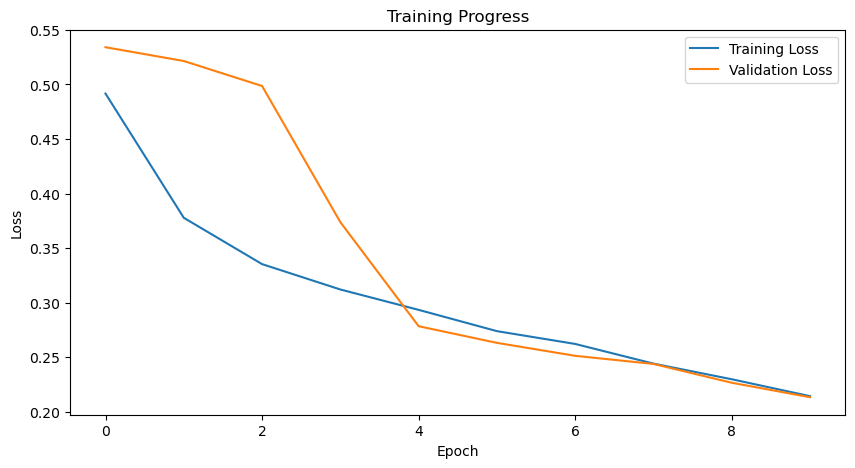

In [8]:
# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.savefig(os.path.join(results_dir, 'training_progress.png'))
plt.show()

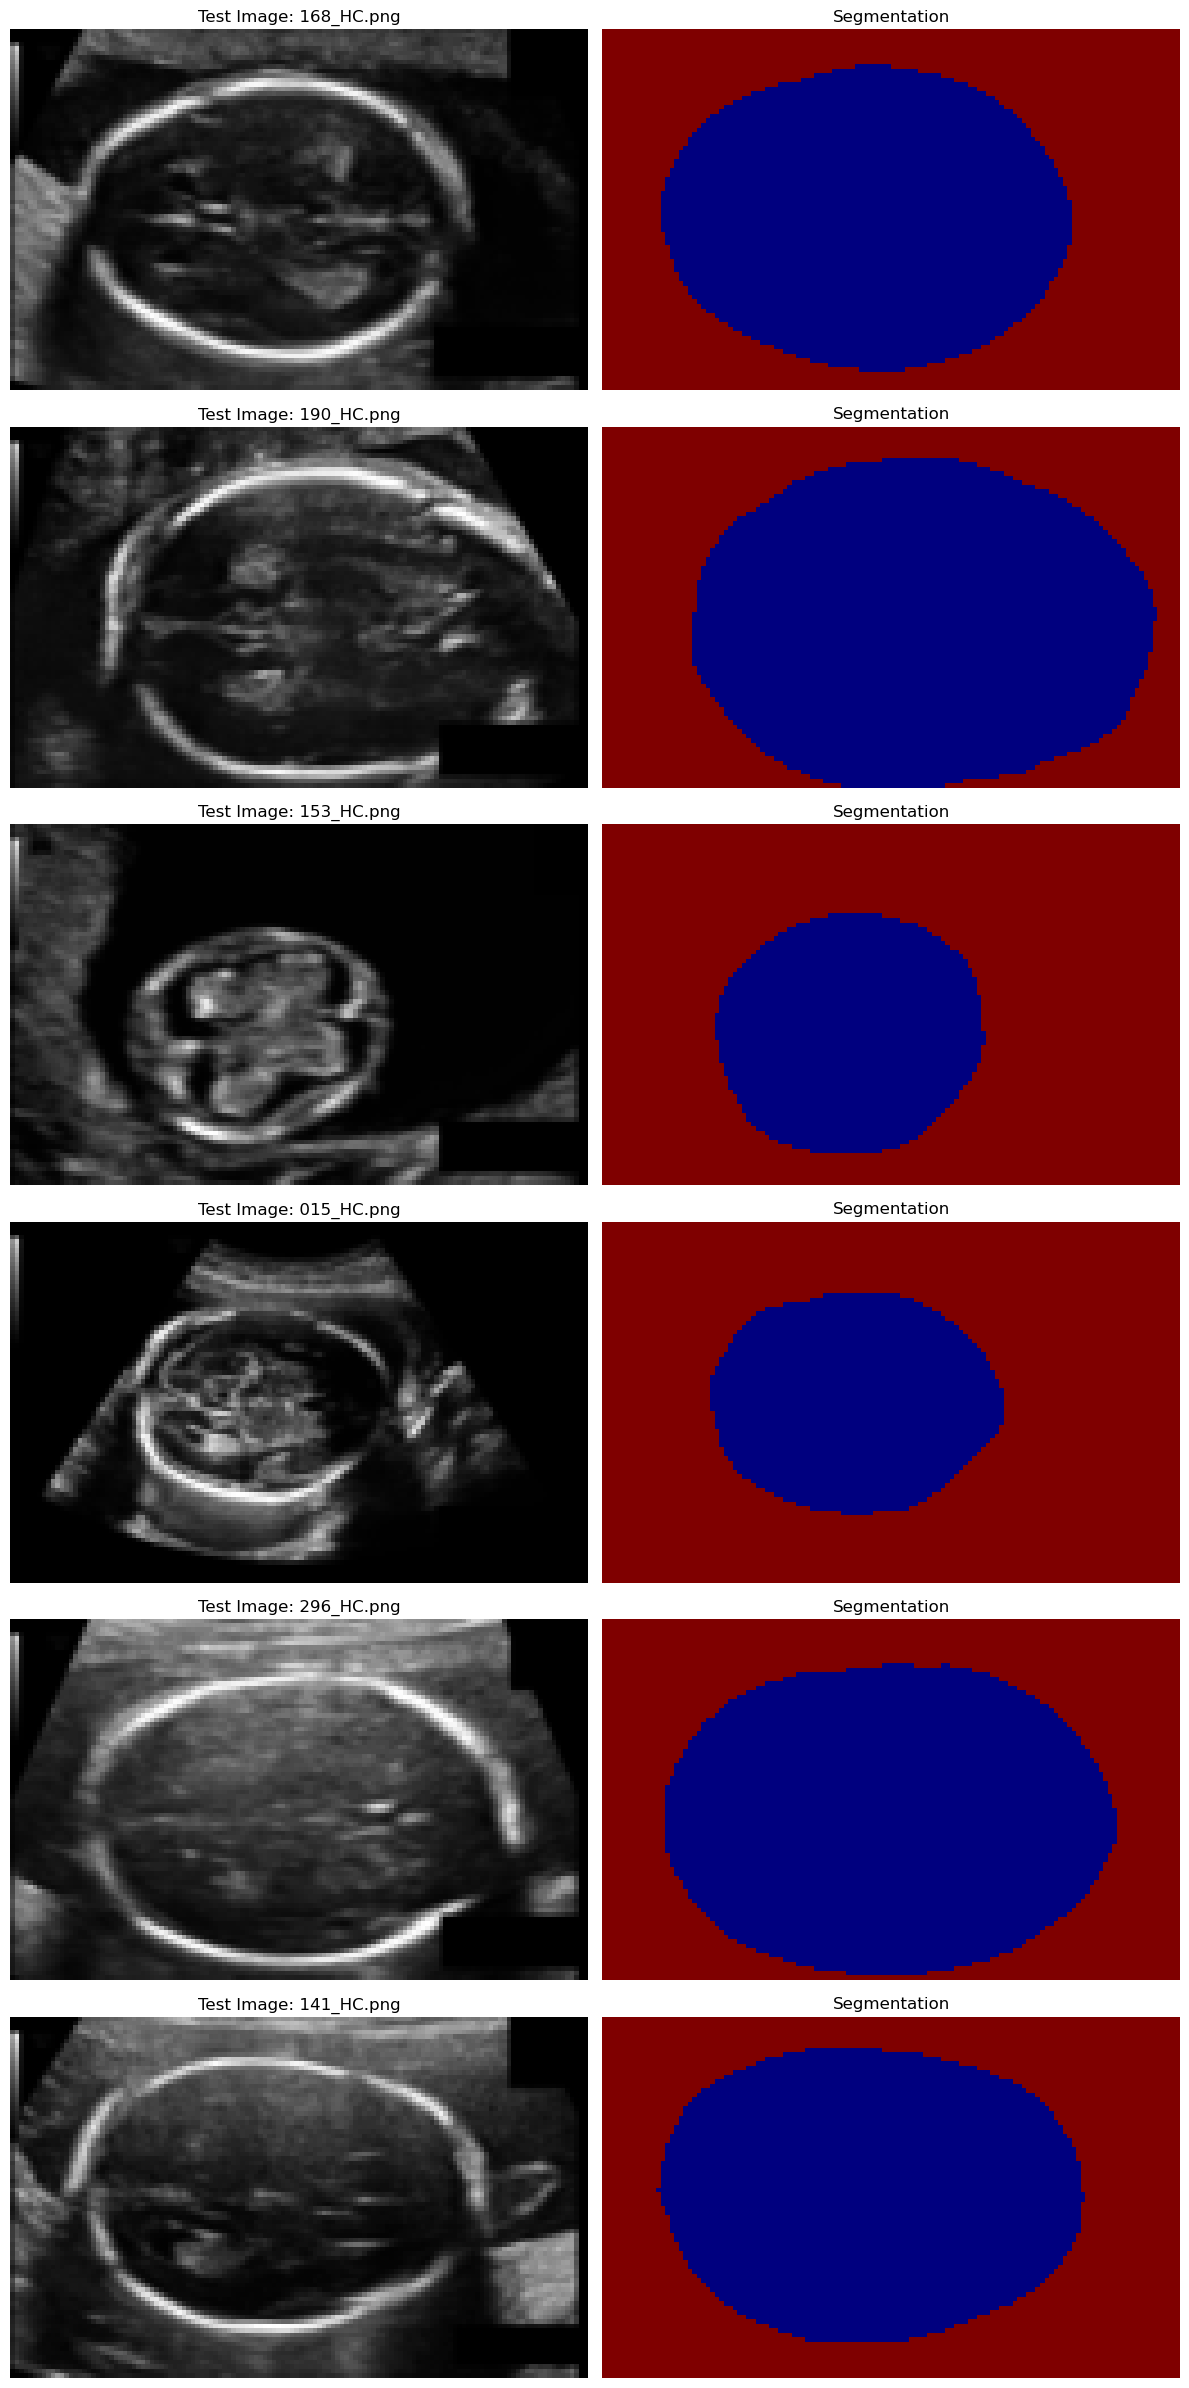

In [9]:
# Visualize test results
if os.path.exists(test_images_dir):
    model.eval()
    test_files = [f for f in os.listdir(test_images_dir) if f.endswith('.png')]
    num_images_to_plot = min(6, len(test_files))
    
    random_indices = random.sample(range(len(test_files)), num_images_to_plot)
    
    fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(12, 4 * num_images_to_plot))
    
    for i, idx in enumerate(random_indices):
        # Load test image
        img_path = os.path.join(test_images_dir, test_files[idx])
        img = Image.open(img_path).convert('L')
        img_resized = img.resize((image_size[1], image_size[0]))
        img_tensor = torch.from_numpy(np.array(img_resized, dtype=np.float32) / 255.0).unsqueeze(0).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            output = model(img_tensor)
            pred = torch.argmax(output, dim=1).cpu().numpy()[0]
        
        # Plot
        axes[i, 0].imshow(np.array(img_resized), cmap='gray')
        axes[i, 0].set_title(f'Test Image: {test_files[idx]}')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(pred, cmap='jet')
        axes[i, 1].set_title('Segmentation')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'test_results.png'))
    plt.show()

In [14]:
# ==================== MODEL VISUALIZATION ====================
print("\n" + "="*60)
print("MODEL ARCHITECTURE VISUALIZATION")
print("="*60)

# 1. Print summary
from torchsummary import summary
print("\n1. Model Summary:")
summary(model, input_size=(1, 80, 128))

# 2. Draw architecture graph
from torchview import draw_graph
print("\n2. Generating architecture diagram...")
model_graph = draw_graph(
    model, 
    input_size=(1, 1, 80, 128),
    graph_name='U-Net Segmentation Architecture',
    expand_nested=True,
    save_graph=True,
    directory=results_dir,
    filename='unet_architecture'
)

# 3. Save as ONNX for Netron
print("\n3. Exporting to ONNX format for interactive visualization...")
dummy_input = torch.randn(1, 1, 80, 128).to(device)
onnx_path = os.path.join(results_dir, "unet_model.onnx")
torch.onnx.export(model, dummy_input, onnx_path, opset_version=11)
print(f"   Model saved to: {onnx_path}")
print(f"   View with: netron {onnx_path}")

# 4. Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n4. Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print("="*60 + "\n")


MODEL ARCHITECTURE VISUALIZATION

1. Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 80, 128]             144
       BatchNorm2d-2          [-1, 16, 80, 128]              32
              ReLU-3          [-1, 16, 80, 128]               0
            Conv2d-4          [-1, 16, 80, 128]           2,304
       BatchNorm2d-5          [-1, 16, 80, 128]              32
              ReLU-6          [-1, 16, 80, 128]               0
         MaxPool2d-7           [-1, 16, 40, 64]               0
            Conv2d-8           [-1, 32, 40, 64]           4,608
       BatchNorm2d-9           [-1, 32, 40, 64]              64
             ReLU-10           [-1, 32, 40, 64]               0
           Conv2d-11           [-1, 32, 40, 64]           9,216
      BatchNorm2d-12           [-1, 32, 40, 64]              64
             ReLU-13           [-1, 32, 40, 64]   


(process:47380): Pango-WARNING **: 18:41:39.298: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.



3. Exporting to ONNX format for interactive visualization...


W0129 18:41:40.494000 32732 site-packages\torch\onnx\_internal\exporter\_compat.py:125] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `UNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


C:\Users\muham\anaconda3\Lib\copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)
The model version conversion is not supported by the onnxscript version converter and fallback is enabled. The model will be converted using the onnx C API (target version: 11).


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Failed to convert the model to the target version 11 using the ONNX C API. The model was not modified
Traceback (most recent call last):
  File "C:\Users\muham\anaconda3\Lib\site-packages\onnxscript\version_converter\__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
        func=_partial_convert_version, model=model
    )
  File "C:\Users\muham\anaconda3\Lib\site-packages\onnxscript\version_converter\_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
  File "C:\Users\muham\anaconda3\Lib\site-packages\onnxscript\version_converter\__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^
        proto, target_version=self.target_version
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "C:\Users\muham\anaconda3\Lib\site-packages\onnx\version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_versio

Applied 36 of general pattern rewrite rules.
   Model saved to: C:\Users\muham\Desktop\ai-imaging\imagingCNN\head_ultrasound_data\head_ultrasound_segmentation\results\unet_model.onnx
   View with: netron C:\Users\muham\Desktop\ai-imaging\imagingCNN\head_ultrasound_data\head_ultrasound_segmentation\results\unet_model.onnx

4. Model Statistics:
   Total parameters: 1,942,306
   Trainable parameters: 1,942,306

